In [6]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import torch
import models
import util
import os
import config
import viz
import scipy.stats
import figs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
DIRS_STYLEGAN = '../data_processed/stylegan2'
DIR_ORIG = '../data/annotation-dataset-stylegan2/images'

In [23]:
regs = [0, 1, 10000]
IM_NUM = 0

In [28]:
ims = []
latents = []
im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM}.jpg'))
for reg in regs:
    folder = f'generated_images_{reg}'
    im_fname = oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.png')
    ims.append(mpimg.imread(im_fname))
    latents.append(np.load(oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.npy')))
    

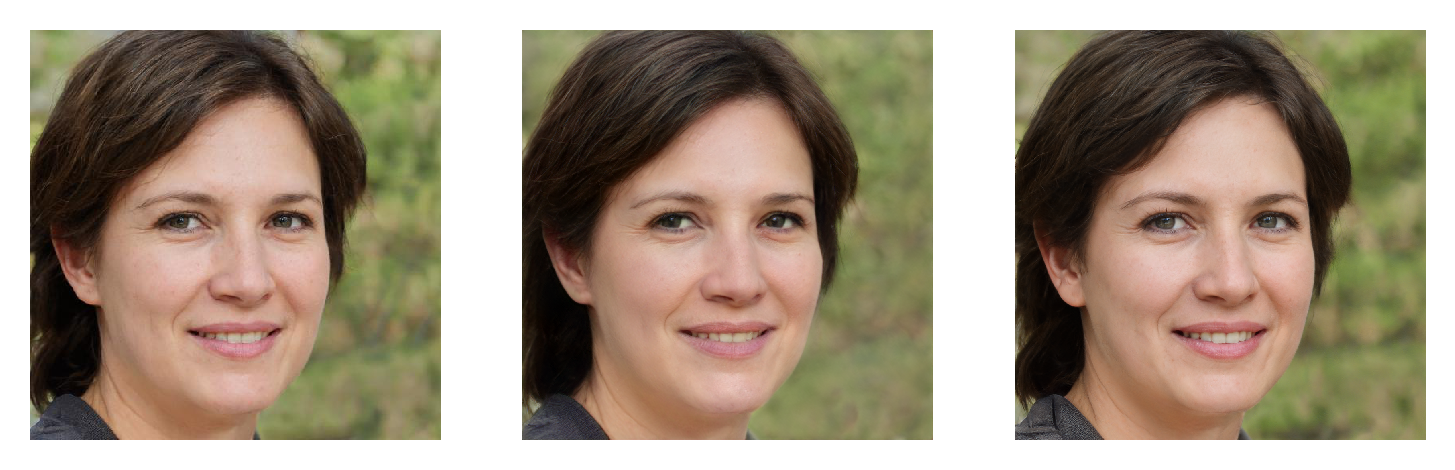

In [37]:
R, C = 1, 3
plt.figure(dpi=300)
plt.subplot(R, C, 1)
util.imshow(im_orig)

for i in range(len(regs)):
    plt.subplot(R, C, 2 + i)
    util.imshow(ims[i])

-0.008783135500996997
0.9999999752526443


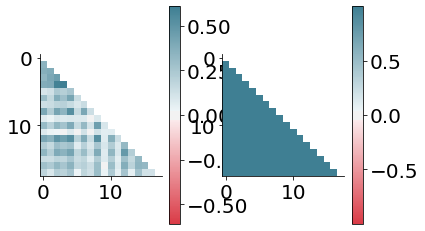

In [40]:
R, C = 1, 2
for i in range(len(regs)):
    plt.subplot(R, C, 1 + i)    
    viz.corrplot(np.corrcoef(latents[i]))
    plt.colorbar()
    print(np.min(np.corrcoef(latents[i])))